In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from itertools import chain
from scipy.spatial.distance import cdist
import scipy as sp
import GPy
import safeopt

In [2]:
# Objective function
# WARNING: SafeOpt has issues with negative function values!
def sphere_broken(x): return -((np.asarray(x)**2).sum(axis=0)) 

def sphere(x): return 100 + sphere_broken(x) 
fun = sphere_broken 

In [3]:
def eval_on_grid(f, xbound, n_steps):
    # This is similar but simpler than what safeopt.linearly_spaced_combinations does.
    x_1 = np.linspace(xbound[0][0], xbound[0][1], n_steps)
    x_2 = np.linspace(xbound[1][0], xbound[1][1], n_steps)
    X,Y = np.meshgrid(x_1, x_2)
    x_matrix = np.column_stack((X.ravel(),Y.ravel()))
    # safeopt.linearly_spaced_combinations returns x_matrix[:, ::-1]
    # Another option would be np.apply_along_axis(function, 1, array)
    y = np.apply_along_axis(fun, 1, x_matrix)
    return x_1, x_2, x_matrix, y

def estimate_lipschitz(f, xbound, n_steps):
    x_1, x_2, x_matrix, y = eval_on_grid(f, xbound=xbound, n_steps = n_steps)
    g1, g2 = np.gradient(y.reshape(n_steps, n_steps), x_1, x_2)
    return max(np.abs(g1).max(), np.abs(g2).max())

bounds = [(-5., 5.),(-8., 2.)]
n_steps = 500
# For simplicity, we use the same bounds for all variables. This could be extended easily to handle different bounds.
x_1, x_2, x_matrix, y = eval_on_grid(fun, bounds, n_steps)
lipschitz = estimate_lipschitz(fun, bounds, n_steps)
print(f'Lipschitz constant = {lipschitz}')
# Setting Safety threshold as 75 percentile
SafeThres = np.quantile(y, 0.75)
print(f'Safe Threshold (.75) = {SafeThres}')
opt_pos = np.argmax(y)
assert y[opt_pos] == fun(x_matrix[opt_pos,:])
print(f'y_opt = {y[opt_pos]}, x_opt = {x_matrix[opt_pos,:]}')

Lipschitz constant = 15.979959919840175
Safe Threshold (.75) = -8.948835546845192
y_opt = -0.00011646539572130657, x_opt = [-0.01002004 -0.00400802]


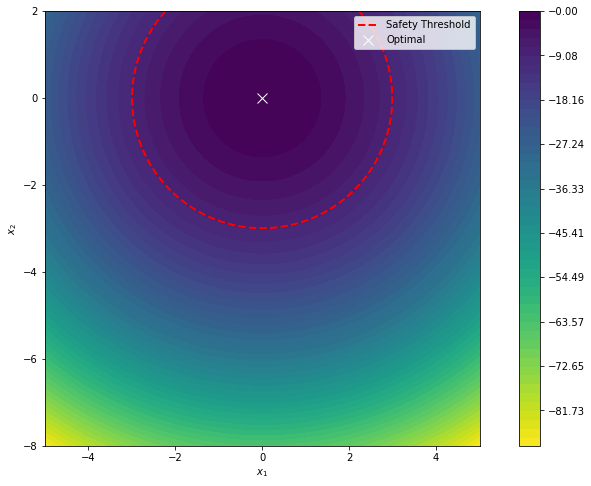

In [4]:
import matplotlib.pyplot as plt
def plot_function(x_1, x_2, y, safe_threshold):
    y_grid = y.reshape(len(x_1), len(x_2))
    # Plot function
    fig, ax = plt.subplots(figsize=(14, 8))
    cntr_f = ax.contourf(x_1, x_2, y_grid, levels=np.linspace(np.min(y), np.max(y), 50),
                         cmap=plt.cm.get_cmap('viridis').reversed())
    cntr_t = ax.contour(x_1, x_2, y_grid, levels=[safe_threshold], colors = "r", linewidths=2, linestyles="dashed")
    o, _ = cntr_t.legend_elements()
    legend_objs = [o[0]]
    legend_labels = ["Safety Threshold"]
    ax.legend(legend_objs, legend_labels)
    ax.set_xlabel('$x_1$'), ax.set_ylabel('$x_2$')
    ax.axis('square')
    fig.colorbar(cntr_f)
    legend = [legend_objs, legend_labels]
    return fig, ax, legend

def plot_optimal(x_opt, fig, ax, legend):
    legend[0] += ax.plot(x_opt[0], x_opt[1], 'x', color='white', markersize=10)
    legend[1] += ["Optimal"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_safeopt(opt, fig, ax, legend):
    legend[0] += ax.plot(opt.parameter_set[opt.S,0], opt.parameter_set[opt.S,1], '.',  color='grey', markersize=5)
    legend[1] += ["Safe set"]
    legend[0] += ax.plot(opt.parameter_set[opt.M,0], opt.parameter_set[opt.M,1], '.', color='m', markersize=5)
    legend[1] += ["Maximizers set"]
    legend[0] += ax.plot(opt.parameter_set[opt.G,0], opt.parameter_set[opt.G,1], '.', color='red', markersize=5,alpha=0.9)
    legend[1] += ["Expanders set"]
    legend[0] += ax.plot(opt.x[:,0], opt.x[:,1], 'x', color='blue', markersize=10)
    legend[1] += ["Evaluated points"]
    return fig, ax, legend

def plot_safe_seed(x_safe_seed, fig, ax, legend):
    o = ax.plot(x_safe_seed[:,0], x_safe_seed[:,1], 'o', markersize=5, color='k')
    legend[0] += o
    legend[1] += ["Initial safe seed"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_all(x_1, x_2, y, safe_threshold, opt, x_safe_seed, x_optimal):
    fig, ax, legend = plot_function(x_1, x_2, y, SafeThres)
    fig, ax, legend = plot_safeopt(opt, fig, ax, legend)
    fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
    plot_optimal(x_optimal, fig, ax, legend)

fig, ax, legend = plot_function(x_1, x_2, y, SafeThres)
plot_optimal(x_matrix[opt_pos,:], fig, ax, legend)
plt.show()

Safe seeds:
 X = [[-0.43086172 -2.18837675]]
 y = [[-4.97463464]]


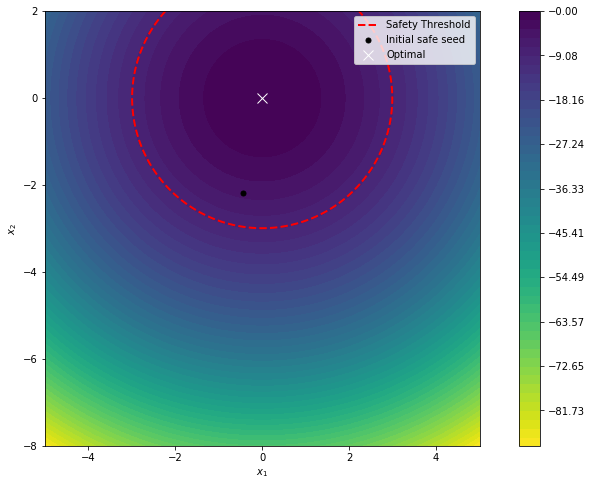

In [5]:
#Random selection (initial safe seed)
from numpy.random import default_rng
random_seed = 42
rng = default_rng(random_seed)
def get_safe_seeds(x_matrix, y, safe_threshold, n):
    y_safe_mask = y > safe_threshold
    pos = rng.choice(y_safe_mask.sum(), size = n, replace=False)
    x_safe_seed = x_matrix[y_safe_mask,:][pos,:]
    y_safe_seed = y[y_safe_mask][pos]
    y_safe_seed = y_safe_seed[:,None]
    print(f'Safe seeds:\n X = {x_safe_seed}\n y = {y_safe_seed}')
    return x_safe_seed, y_safe_seed 

x_safe_seed, y_safe_seed = get_safe_seeds(x_matrix, y, SafeThres, n=1)

fig, ax, legend = plot_function(x_1, x_2, y, SafeThres)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_matrix[opt_pos,:], fig, ax, legend)
plt.show()

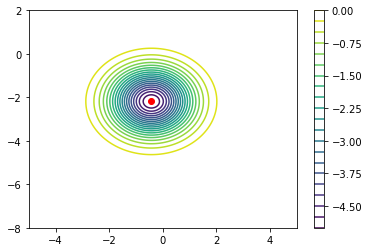

In [6]:
def run_safeopt(opt, fun, iterations, plot=False):
    for i in range(iterations):
        # Obtain next query point
        x_next = opt.optimize()
        # Get a measurement from the real system
        y_meas = fun(x_next)
        # Add this to the GP model
        opt.add_new_data_point(x_next, y_meas)
        print(f'evals={len(opt.y)}\ty={y_meas}\tsafe={y_meas >= SafeThres}')
        if plot: opt.plot(500)

def safeopt_stats(opt, fun):
    emax = opt.get_maximum()
    print(f'Estimated maximum = {emax} true_y = {fun(emax[0])}')
    print(f'Max found: {np.max(opt.y)}')
    print(f'Number of failures: {np.sum(opt.y < opt.fmin)}')
    
# Measurement noise, I will add the variance soon
noise_var = 0.00 ** 2
# Define Kernel (2-dimensional RBF kernel)
kernel = GPy.kern.RBF(input_dim=len(bounds), ARD=True)
# The statistical model of our objective function
gp = GPy.models.GPRegression(x_safe_seed, y_safe_seed, kernel, noise_var=noise_var)

# The optimization routine
# FIXME: Why beta = 1.96 ?
# FIXME: It is not clear what is threshold
opt = safeopt.SafeOpt(gp, parameter_set=x_matrix, fmin=[SafeThres], lipschitz=lipschitz, beta = 1.96, threshold=0)
# here, use lipschitz=None for modified safeopt
# Plot initial safe seed
opt.plot(500)

evals=2	y=-89.0	safe=False
evals=3	y=-66.22900711242123	safe=False
evals=4	y=-25.40611885092831	safe=False
evals=5	y=-28.609238517114385	safe=False
evals=6	y=-44.473030228794265	safe=False
evals=7	y=-35.051060035903475	safe=False
evals=8	y=-4.506122465371624	safe=True
evals=9	y=-37.200529315143314	safe=False
evals=10	y=-89.0	safe=False
evals=11	y=-11.529467753141553	safe=False


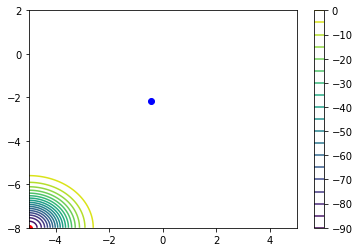

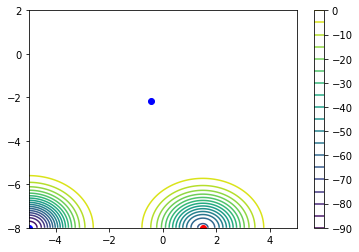

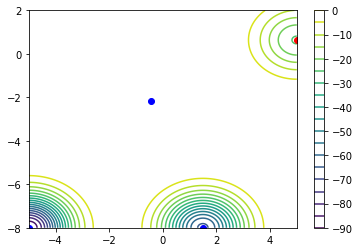

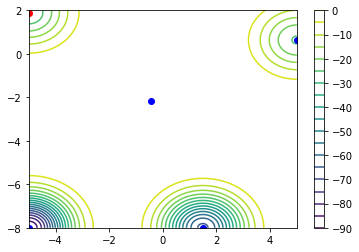

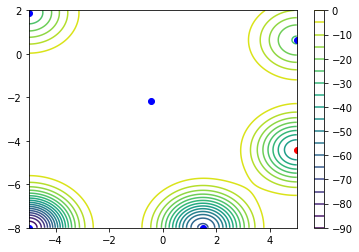

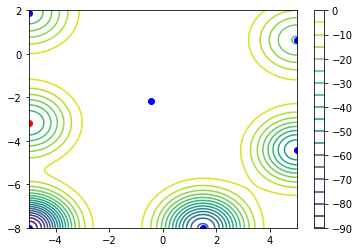

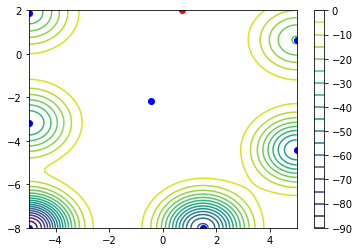

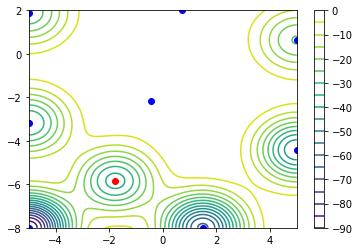

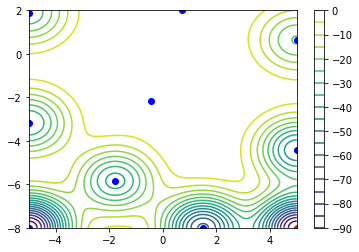

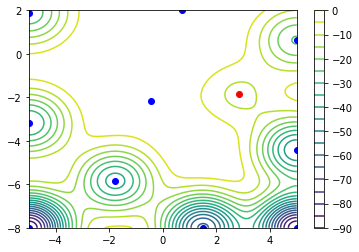

In [7]:
# do 10 iterations
run_safeopt(opt, fun, 10, plot=True)

Estimated maximum = (array([-1.85370741,  0.37675351]), -2.13507585258988) true_y = -3.5781743848418284
Max found: -4.506122465371624
Number of failures: 9


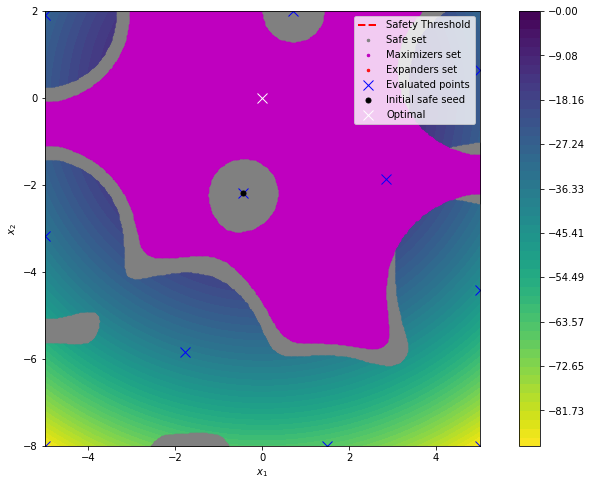

In [8]:
safeopt_stats(opt, fun)
plot_all(x_1, x_2, y, SafeThres, opt, x_safe_seed, x_matrix[opt_pos,:])

In [ ]:
# do 40 more iterations (so far, 50 iterations)
run_safeopt(opt, fun, 40, plot=True)

evals=12	y=-25.77647880932205	safe=False
evals=13	y=-4.955277288043019	safe=True
evals=14	y=-25.41639993413681	safe=False
evals=15	y=-50.43172115774635	safe=False
evals=16	y=-18.025987847438365	safe=False
evals=17	y=-65.10692326536841	safe=False
evals=18	y=-13.586407283504887	safe=False
evals=19	y=-1.187902859827871	safe=True
evals=20	y=-28.95204838534785	safe=False
evals=21	y=-11.011879470363576	safe=False
evals=22	y=-16.588322938462095	safe=False
evals=23	y=-5.619371006542143	safe=True
evals=24	y=-9.587708483098462	safe=False
evals=25	y=-14.216926839651245	safe=False
evals=26	y=-10.360074859137113	safe=False
evals=27	y=-0.5707969044301033	safe=True
evals=28	y=-4.630539636386999	safe=True
evals=29	y=-5.647563664402954	safe=True
evals=30	y=-0.704210023252919	safe=True
evals=31	y=-5.788366311781882	safe=True
evals=32	y=-9.097750611443328	safe=False
evals=33	y=-1.4104722470994109	safe=True
evals=34	y=-7.739844418295506	safe=True
evals=35	y=-6.612620029638434	safe=True
evals=36	y=-7.46394

In [ ]:
safeopt_stats(opt, fun)
plot_all(x_1, x_2, y, SafeThres, opt, x_safe_seed, x_matrix[opt_pos,:])

In [ ]:
#do 60 iterations (so far 100 iterations)
run_safeopt(opt, fun, 60, plot=False) # This is very slow!

In [ ]:
safeopt_stats(opt, fun)
plot_all(x_1, x_2, y, SafeThres, opt, x_safe_seed, x_matrix[opt_pos,:])